# Regression challenge

## Setting the paths, importing the libraries and the data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


notebook = 'classification.ipnyb'
path = os.path.dirname(os.path.abspath(notebook))+'/data/'
train_path = path+'regression_train.csv'
test_path = path+'regression_test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.head()

target        X1         X2         X3        X4         X5  X6  \
0          NaN -0.546168        NaN  47.063305  1.611370 -65.882137   0   
1    47.735389  3.074317  -2.836000  49.396649  0.261998 -66.570716   0   
2          NaN -1.485531 -13.102537  42.367991  3.991558 -67.108014   8   
3   908.202209  6.907396  -0.308967  57.228787  0.256771 -66.181266   5   
4  1640.461863  1.916788   3.460290  51.703375  2.463790 -65.143663   5   

          X7  
0 -16.672865  
1  -6.664599  
2 -30.790962  
3  -0.726072  
4   8.131680

## Setting the seeds for reproducibility

In [72]:
import random 

seed_value = 42
random.seed(seed_value) 
np.random.seed(seed_value)

## Exploratory analysis

There is little info about this data but we can still explore it a little bit:
* null/missing values
* variables distribution
* variable correlation
* distribution according to the target variable

In [3]:
#Constructing a trainframe with the variable types and missing values per column
consistency = pd.DataFrame({'columns' : train.columns,
                    'type': train.dtypes,
                    'missing' : train.isna().sum(),
                    'size' : train.shape[0],
                    'unique': train.nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

columns     type  missing  size  unique  percentage
target  target  float64      327  1042     715        0.31
X1          X1  float64        0  1042    1042        0.00
X2          X2  float64       11  1042    1031        0.01
X3          X3  float64        0  1042    1038        0.00
X4          X4  float64        0  1042    1042        0.00
X5          X5  float64        0  1042    1042        0.00
X6          X6    int64        0  1042       3        0.00
X7          X7  float64        0  1042    1042        0.00

There are missing values in the target variable so we'll start by removing those rows.
If removing those rows also removes the rows with missing values in X2 we're set, otherwise we need to handle these as well.

In [6]:
train.loc[~train.loc[:,'target'].isna()].isna().sum()

target    0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
dtype: int64

When removing the rows with missing values on the target variable we also remove the rows with missing values on X2.
So we're setting a new train dataframe without these rows.

In [7]:
train_noNaN = train.loc[~train.loc[:,'target'].isna()]

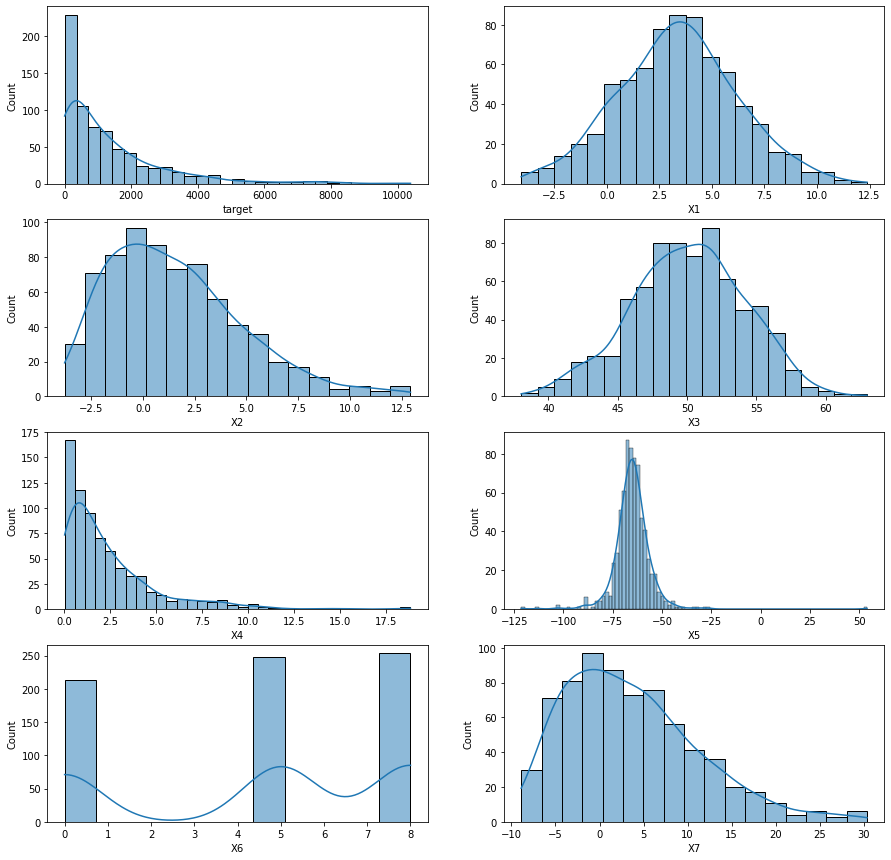

In [20]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
for variable, subplot in zip(train_noNaN.columns, ax.flatten()):
    sns.histplot(train_noNaN[variable], ax=subplot,kde=True)

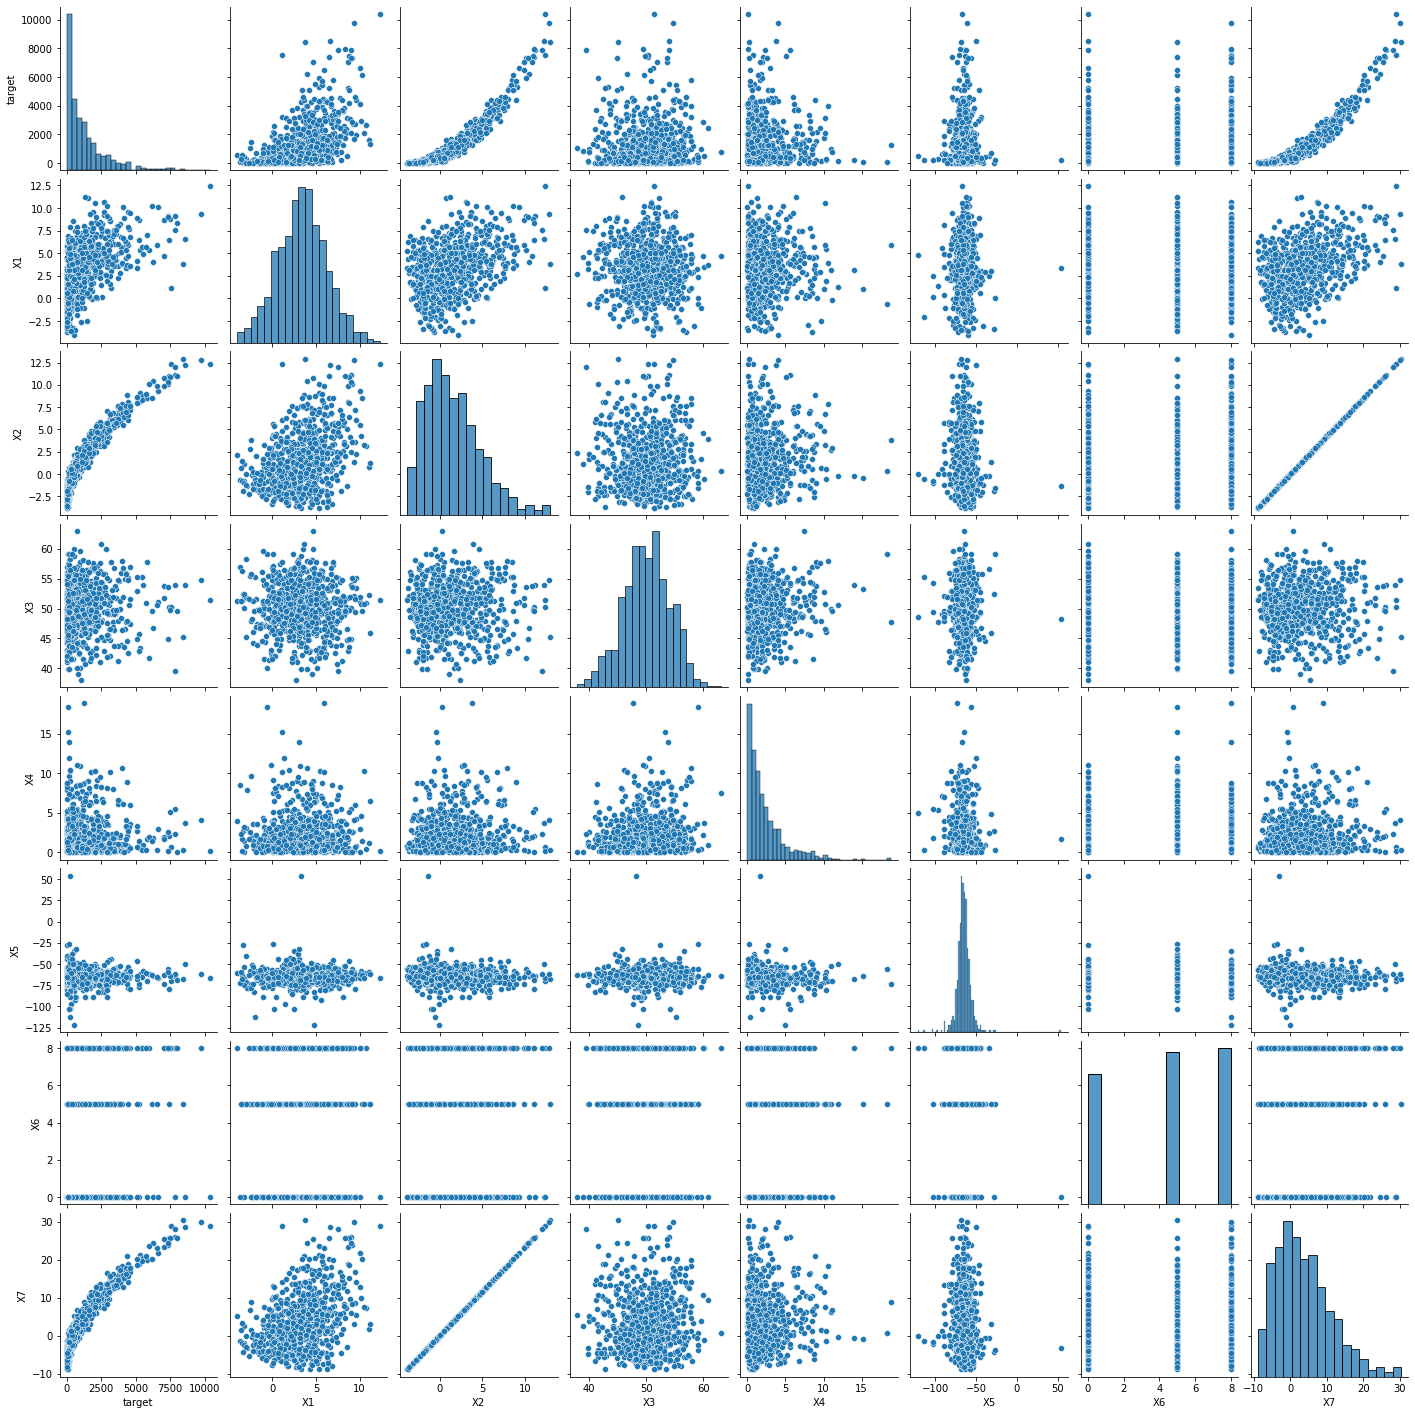

In [22]:
sns.pairplot(train_noNaN, kind="scatter")
plt.show()

We can see that X1, X2, and X7 have a linear positive relationship with the target variable. So the hypothesis arises that these are the most relevant features.

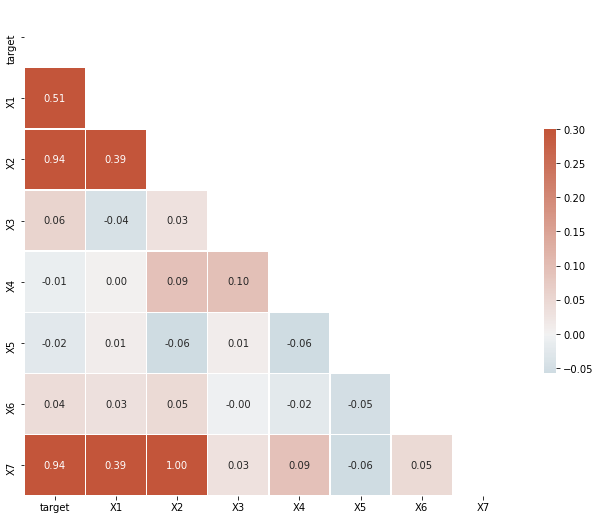

In [23]:
# Compute the correlation matrix
corr = train_noNaN.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [33]:
factor = train_noNaN['X2']/train_noNaN['X7']
factor.value_counts()

0.425532    266
0.425532    216
0.425532    101
0.425532     80
0.425532     25
0.425532     24
0.425532      2
0.425532      1
dtype: int64

In regression models we should keep only one of highly correlated features, details about why can be found [here](https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e).

With that being said we are going to exclude X7 simply because it has the highest values.

In [42]:
train_cleaned = train_noNaN.loc[:,train_noNaN.columns != 'X7']

train_cleaned

target        X1        X2         X3        X4         X5  X6
1       47.735389  3.074317 -2.836000  49.396649  0.261998 -66.570716   0
3      908.202209  6.907396 -0.308967  57.228787  0.256771 -66.181266   5
4     1640.461863  1.916788  3.460290  51.703375  2.463790 -65.143663   5
5      750.197635  1.090232  1.256970  50.290722  1.477950 -58.637657   5
6     1042.939629  1.145275  2.354394  51.601926  3.968927 -60.466758   5
...           ...       ...       ...        ...       ...        ...  ..
1036  1459.419250  0.588939  3.120751  51.632211  0.427576 -72.665728   8
1037  4296.426459  5.375810  6.937947  55.810467  1.698025 -65.819509   8
1038    54.530919  0.619207 -1.925819  48.168606  1.357223 -65.385243   8
1039  1636.535078  4.548172  2.886253  47.775525  1.278439 -56.312543   8
1041  2951.647675  6.002320  5.760220  41.926049  3.562797 -81.111346   8

[715 rows x 7 columns]

Features X2 to X6 have very low correlation to the target, one possible test is running the model with only X1 and X2.

But for now we'll proceed with all the remaining features.

The features have quite different scales, so a preprocessing step is needed.

Since there is one discrete feature(X6) we'll normalize all features.

We'll also need to store this transformer to apply the same normalization to the test set.

In [49]:
from sklearn.preprocessing import MinMaxScaler

X_train = train_cleaned.loc[:,train_cleaned.columns != 'target'].values #returns a numpy array
y_train = train_cleaned['target']


transformer = MinMaxScaler().fit(X_train)
X_train_transformed = transformer.transform(X_train)

#just to check the transformation
df = pd.DataFrame(X_train_transformed)
df

0         1         2         3         4      5
0    0.434627  0.056882  0.455597  0.013412  0.312937  0.000
1    0.667491  0.208086  0.769675  0.013134  0.315158  0.625
2    0.364306  0.433617  0.548100  0.130508  0.321075  0.625
3    0.314092  0.301783  0.491451  0.078079  0.358174  0.625
4    0.317436  0.367447  0.544032  0.210555  0.347744  0.625
..        ...       ...       ...       ...       ...    ...
710  0.283638  0.413301  0.545246  0.022218  0.278182  1.000
711  0.574446  0.641701  0.712799  0.089783  0.317221  1.000
712  0.285477  0.111342  0.406351  0.071658  0.319697  1.000
713  0.524166  0.399270  0.390588  0.067469  0.371432  1.000
714  0.612507  0.571233  0.156017  0.188956  0.230023  1.000

[715 rows x 6 columns]

We must repeat these steps for the test set.

In [50]:
#Constructing a testframe with the variable types and missing values per column
consistency_test = pd.DataFrame({'columns' : test.columns,
                    'type': test.dtypes,
                    'missing' : test.isna().sum(),
                    'size' : test.shape[0],
                    'unique': test.nunique()})
consistency_test['percentage'] = round(consistency_test['missing'] / consistency_test['size'],2)
consistency_test

columns     type  missing  size  unique  percentage
target  target  float64       81   261     180        0.31
X1          X1  float64        0   261     261        0.00
X2          X2  float64        0   261     261        0.00
X3          X3  float64        0   261     261        0.00
X4          X4  float64        0   261     261        0.00
X5          X5  float64        0   261     261        0.00
X6          X6    int64        0   261       3        0.00
X7          X7  float64        0   261     261        0.00

In [51]:
test_noNaN = test.loc[~test.loc[:,'target'].isna()]

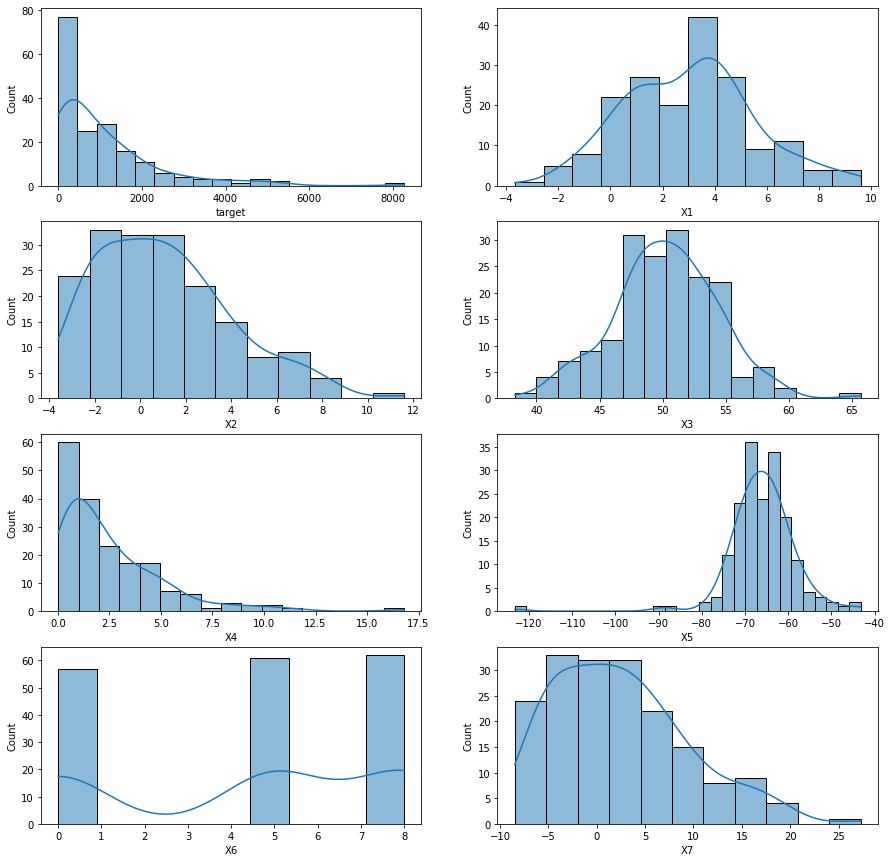

In [52]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
for variable, subplot in zip(test_noNaN.columns, ax.flatten()):
    sns.histplot(test_noNaN[variable], ax=subplot,kde=True)

 Let's run a Kolmogorov-Smirnov test to verify the train and test samples come from the same distribution.

In [67]:
from scipy import stats

print('X1: ' + str(stats.ks_2samp(train_noNaN.X1, test_noNaN.X1)))
print('X2: ' + str(stats.ks_2samp(train_noNaN.X2, test_noNaN.X2)))
print('X3: ' + str(stats.ks_2samp(train_noNaN.X3, test_noNaN.X3)))
print('X4: ' + str(stats.ks_2samp(train_noNaN.X4, test_noNaN.X4)))
print('X5: ' + str(stats.ks_2samp(train_noNaN.X5, test_noNaN.X5)))
print('X7: ' + str(stats.ks_2samp(train_noNaN.X7, test_noNaN.X7)))

X1: KstestResult(statistic=0.09926184926184926, pvalue=0.10866823812277326)
X2: KstestResult(statistic=0.08480963480963481, pvalue=0.236257432577895)
X3: KstestResult(statistic=0.05551670551670552, pvalue=0.7417119655816915)
X4: KstestResult(statistic=0.06297591297591297, pvalue=0.5920406107156735)
X5: KstestResult(statistic=0.09215229215229215, pvalue=0.16167648842907079)
X7: KstestResult(statistic=0.08480963480963481, pvalue=0.236257432577895)


All p-values are above 10% so we cannot reject the null hypothesis (the sets come from the same distribution).

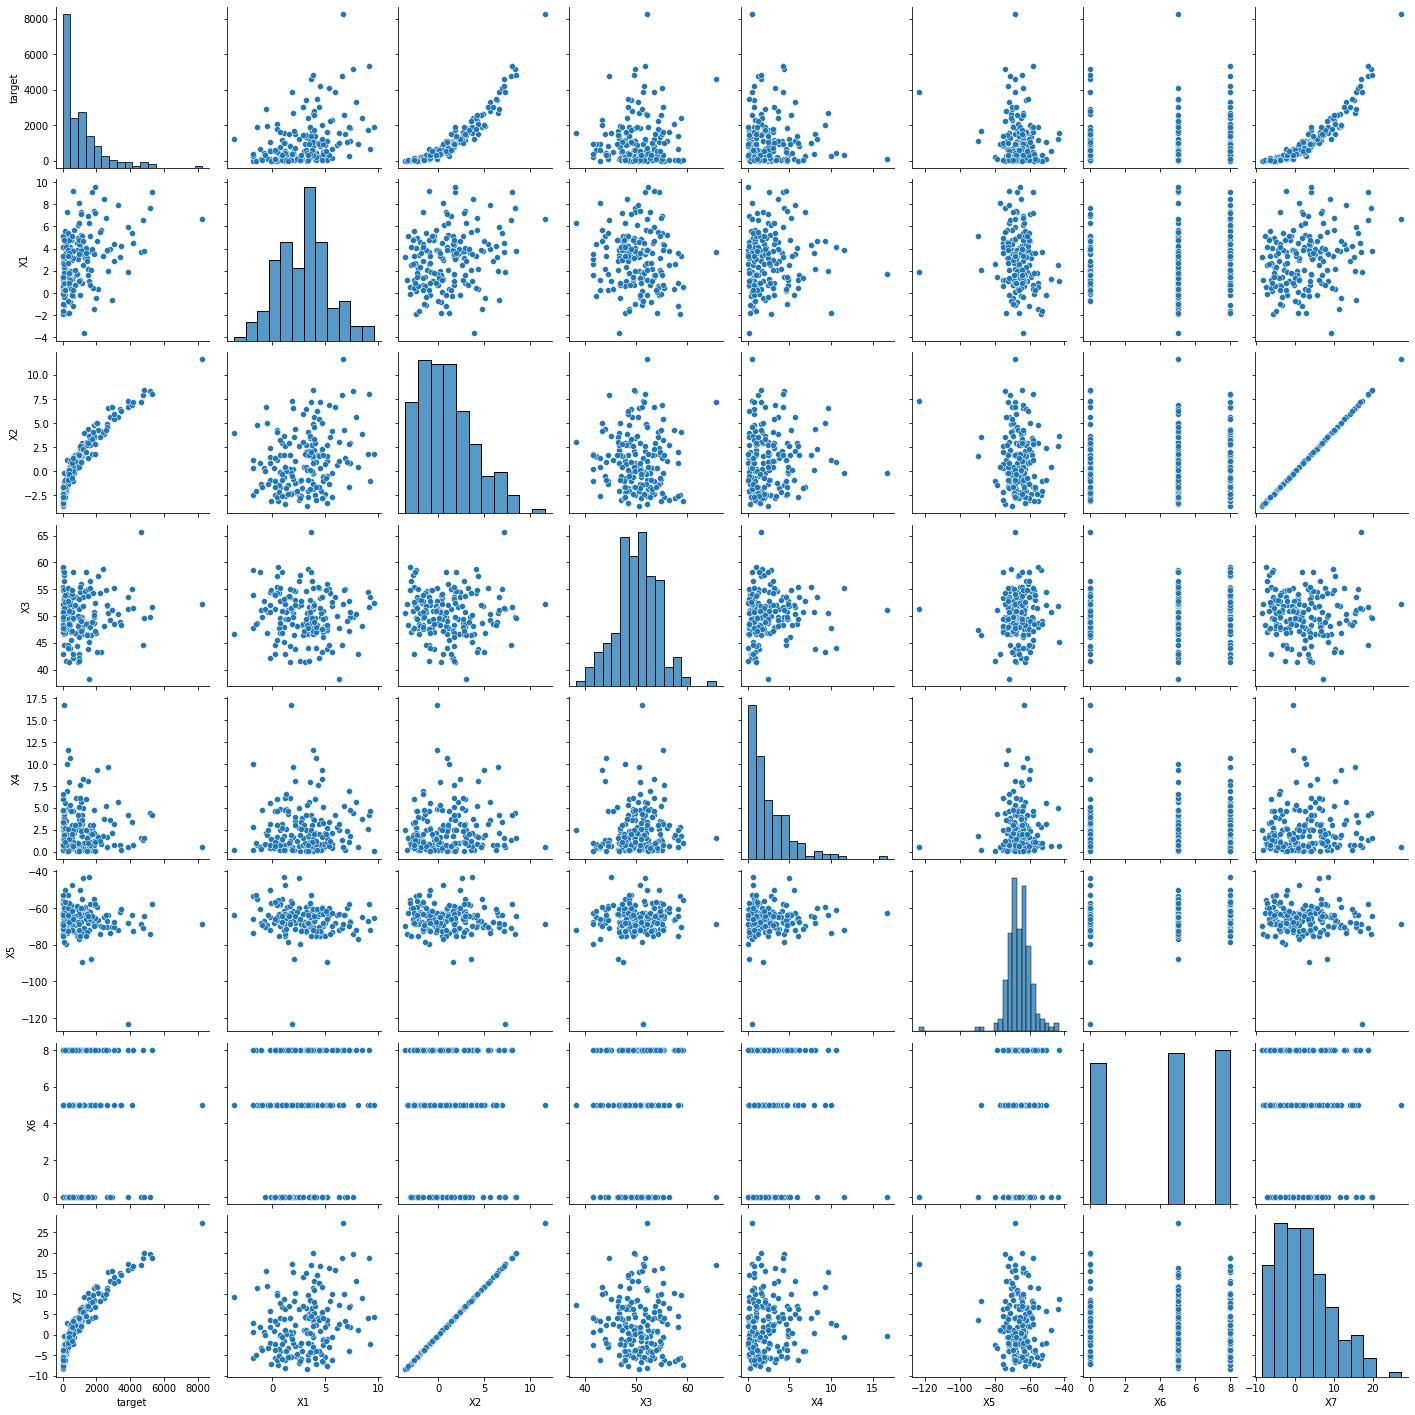

In [69]:
sns.pairplot(test_noNaN, kind="scatter")
plt.show()

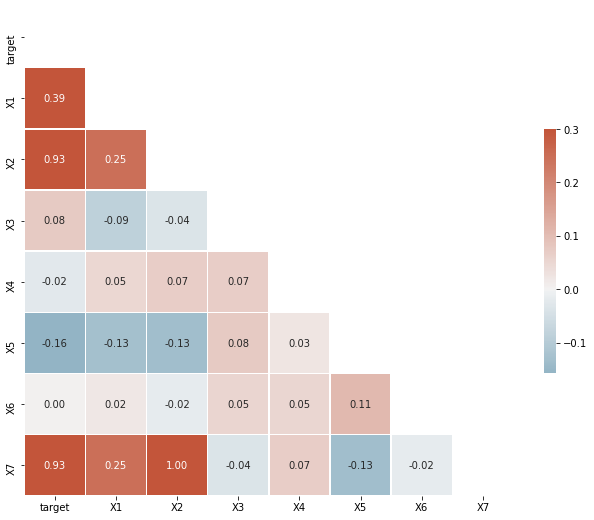

In [68]:
# Compute the correlation matrix
corr = test_noNaN.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [70]:
test_cleaned = test_noNaN.loc[:,test_noNaN.columns != 'X7']

In [71]:
X_test = test_cleaned.loc[:,test_cleaned.columns != 'target'].values #returns a numpy array
y_test = test_cleaned['target']


X_test_transformed = transformer.transform(X_test)

#just to check the transformation
df = pd.DataFrame(X_test_transformed)
df

0         1         2         3         4      5
0    0.260669  0.079900  0.529518  0.246338  0.305504  0.625
1    0.378929  0.486121  0.232320  0.428672  0.302475  1.000
2    0.561721  0.199491  0.236431  0.071254  0.314823  0.000
3    0.446919  0.010737  0.505098  0.131027  0.293544  1.000
4    0.134407  0.082439  0.827078  0.149783  0.386631  0.625
..        ...       ...       ...       ...       ...    ...
175  0.262507  0.129509  0.639575  0.060218  0.368301  1.000
176  0.344329  0.403664  0.629320  0.053883  0.326259  0.000
177  0.557666  0.187747  0.671113  0.104540  0.340916  1.000
178  0.261239  0.310992  0.194874  0.033503  0.315751  0.000
179  0.186926  0.130797  0.471146  0.252470  0.296334  0.625

[180 rows x 6 columns]

## Model training and evaluation

We'll start with a more simple regression model such as Logistic Regression to set a baseline and go from there.

In [108]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_transformed, y_train)

LinearRegression()

## Model comparison metrics

The evalaution metrics have already been set:

* R2, 
* Root Mean Squared Error (RMSE),
* and Pearson correlation coefficient.

In [109]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

y_pred = lr.predict(X_test_transformed)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
corr_test = pearsonr(y_test,y_pred)


print("R2 Score: %.4f" % (r2_test))
print("RMSE: %.2f" % (rmse_test))
print("Pearson correlation: %.3f" % (corr_test[0]))

R2 Score: 0.8976
RMSE: 404.20
Pearson correlation: 0.954


In [110]:
from sklearn.linear_model import ElasticNet

en = ElasticNet(random_state=seed_value)
en.fit(X_train_transformed, y_train)

ElasticNet(random_state=42)

In [111]:
y_pred = en.predict(X_test_transformed)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
corr_test = pearsonr(y_test,y_pred)


print("R2 Score: %.4f" % (r2_test))
print("RMSE: %.2f" % (rmse_test))
print("Pearson correlation: %.3f" % (corr_test[0]))

R2 Score: 0.1162
RMSE: 1187.58
Pearson correlation: 0.930


In [112]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=seed_value)
lasso.fit(X_train_transformed, y_train)

Lasso(random_state=42)

In [113]:
y_pred = lasso.predict(X_test_transformed)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
corr_test = pearsonr(y_test,y_pred)


print("R2 Score: %.4f" % (r2_test))
print("RMSE: %.2f" % (rmse_test))
print("Pearson correlation: %.3f" % (corr_test[0]))

R2 Score: 0.8982
RMSE: 402.96
Pearson correlation: 0.954


## Hyperparemeter GridSearch

In [114]:
from sklearn.model_selection import GridSearchCV

#Since it's a regression problem we will use R2 as the parameter for scoring


param_test1 = {
    'alpha':[0.1, 0.5, 0.7, 1.0],
    'fit_intercept':[True,False],
    'positive':[True,False],
    'selection':['cyclic','random'],
    'random_state':[seed_value]

}

gsearch1 = GridSearchCV(estimator = Lasso(random_state=seed_value), 
                        param_grid = param_test1, 
                        scoring='r2',
                        n_jobs=-1,
                        cv=5,
                       verbose=2)

gsearch1.fit(X_train_transformed, y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.2s finished


({'alpha': 0.5,
  'fit_intercept': True,
  'positive': False,
  'random_state': 42,
  'selection': 'cyclic'},
 0.9135433980385554)

In [115]:
lasso = Lasso(alpha=0.5,
              fit_intercept=True,
              positive=False,
              selection='cyclic',
              random_state=seed_value)

lasso.fit(X_train_transformed, y_train)

Lasso(alpha=0.5, random_state=42)

In [117]:
y_pred = lasso.predict(X_test_transformed)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
corr_test = pearsonr(y_test,y_pred)


print("R2 Score: %.4f" % (r2_test))
print("RMSE: %.2f" % (rmse_test))
print("Pearson correlation: %.3f" % (corr_test[0]))

R2 Score: 0.8980
RMSE: 403.48
Pearson correlation: 0.954


We can look at the coeficients to see which features are more relevant.

Let's compare the coeficients in the lasso and linear regressions.

In [120]:
lasso.coef_

array([ 1585.9815423 ,  7222.14846186,   441.73873792, -1123.40664846,
         344.58819582,   -21.466312  ])

In [119]:
lr.coef_

array([ 1597.59174648,  7235.58992923,   462.23921005, -1152.24974361,
         510.96011918,   -24.01900943])

Both of them indicate that X1, X2 and X4 are the more relevant features.

So we'll run the models with only these features.

In [125]:
X_train_high_coef = pd.DataFrame(X_train_transformed)[[0,1,3]]
X_test_high_coef = pd.DataFrame(X_test_transformed)[[0,1,3]]

In [126]:
lr = LinearRegression()
lr.fit(X_train_high_coef, y_train)

y_pred = lr.predict(X_test_high_coef)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
corr_test = pearsonr(y_test,y_pred)


print("R2 Score: %.4f" % (r2_test))
print("RMSE: %.2f" % (rmse_test))
print("Pearson correlation: %.3f" % (corr_test[0]))

R2 Score: 0.8855
RMSE: 427.49
Pearson correlation: 0.949


In [127]:
lasso = Lasso(random_state=seed_value)

lasso.fit(X_train_high_coef, y_train)

y_pred = lasso.predict(X_test_high_coef)

r2_test = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared = False)
corr_test = pearsonr(y_test,y_pred)


print("R2 Score: %.4f" % (r2_test))
print("RMSE: %.2f" % (rmse_test))
print("Pearson correlation: %.3f" % (corr_test[0]))

R2 Score: 0.8865
RMSE: 425.50
Pearson correlation: 0.949


Both of them decreased slightly.

If feature size was an issue, this scenario would likely be considered.

## Summary

In [128]:
summary = pd.DataFrame(np.array([[0.8976, 404.2, 0.954], [0.1162, 1187.58, 0.930], [0.8982, 402.96, 0.954]]), 
                       index=['Linear Regression','ElasticNet', 'Lasso'],
                       columns=['R2', 'RMSE', 'Pearson'])

summary

R2     RMSE  Pearson
Linear Regression  0.8976   404.20    0.954
ElasticNet         0.1162  1187.58    0.930
Lasso              0.8982   402.96    0.954

## Conclusion

Linear regression and lasso perform very similar according to these metrics.
So I would pick linear regression at this point since it is a simpler model.

However there is an higher chance of performance drifting due with a linear regression, which means this choice had to be monitored frequently.

Adittionaly other types of regression models, like random forest regressor, could be tested for performance increased.

We could also look for outliers, and remove them if there are any since models like linear regression are very sensible to them.